In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../DB_access')
import credentials as cred
from sqlalchemy import create_engine

### Load the data

In [2]:
driver = cred.driver()
user = cred.user()
password = cred.password()
ip = cred.ip()
database = cred.database()

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [3]:
items = pd.read_sql('items', con = engine)

Before looking at similarities, we will drop the orders related to 'El Gran Recapte' as they are considered outliers

In [4]:
items = items[items['Vendor'] != 'Gran Recapte']

We will also drop the orders with tag 'Cesta' as they refer to a new method of selling and are also considered outliers

In [5]:
items = items[items['tags'] != 'Cesta']

### Create a data frame that contains the total quantity of each product purchased by each order

In [6]:
rec = items.groupby(['Name', 'tags']).sum()[['Lineitem quantity']]

### Create a product by order matrix

In [7]:
df_pivot = rec.pivot_table(index='Name', columns='tags', values='Lineitem quantity').fillna(0)
df_pivot.head()

tags,Aceite,Acelgas,Agua,Aguacate,Ajo,Albaricoque,Albóndigas,Alcachofa,Almejas,Almendra,...,Spaghetti,Sumaia,Ternera,Tomate,Tortilla,Uva,Vaca,Yogures,Zanahoria,salchichón
Name,,,,,,,,,,,,,,,,,,,,,
#1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create an order similarity matrix

In [8]:
from scipy.spatial.distance import pdist, squareform
similarity_matrix = squareform(pdist(df_pivot.T, 'cosine'))
similarity_matrix

array([[0.        , 0.79955407, 0.5       , ..., 1.        , 0.95890025,
        1.        ],
       [0.79955407, 0.        , 1.        , ..., 1.        , 0.78031261,
        1.        ],
       [0.5       , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.95890025, 0.78031261, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ]])

### Top 5 most similar orders for a specific order.

In [9]:
similarity_df = pd.DataFrame(similarity_matrix, index=df_pivot.columns, columns=df_pivot.columns)

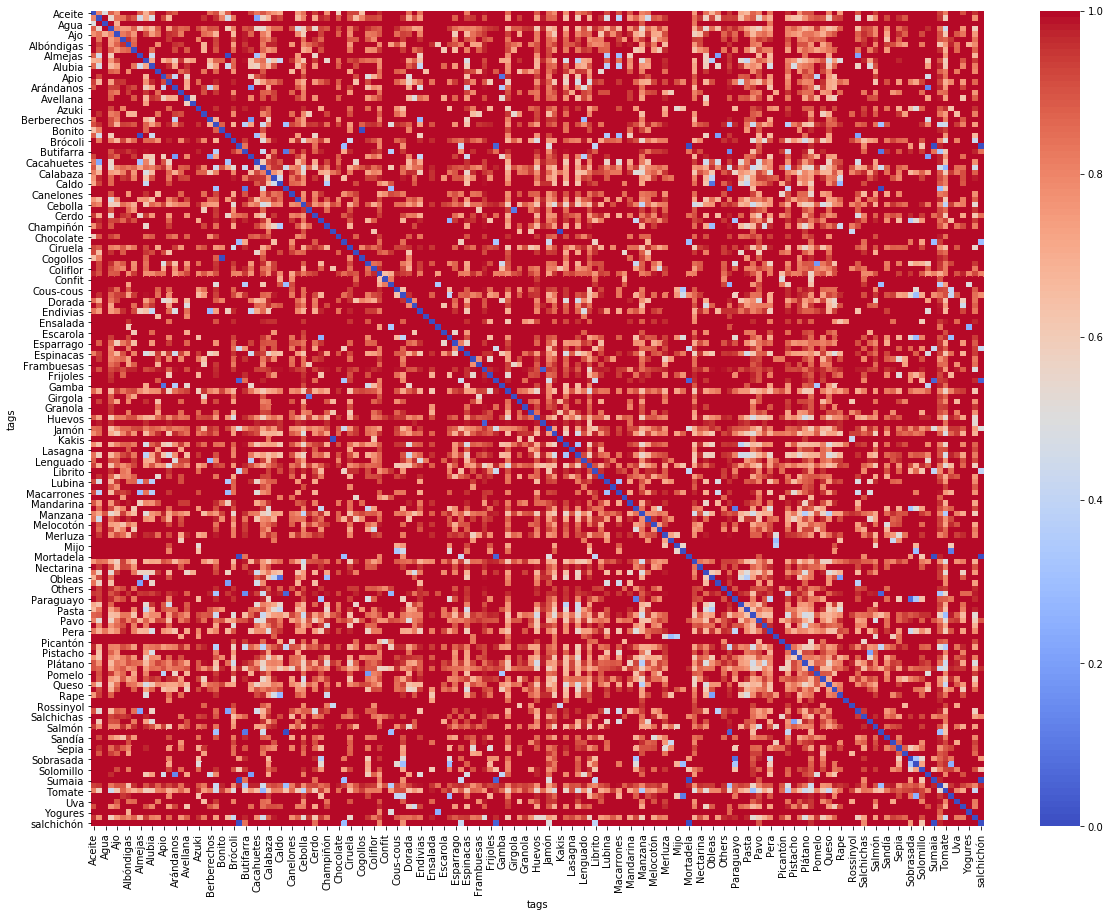

In [10]:
plt.figure(figsize=(20,15))
cmap = sns.color_palette("coolwarm", 128)
sns.heatmap(similarity_df, cmap=cmap)

plt.show()

We see that orders #1061, #1064, #1004 are very similiar, let's take a look at the items they have to check whether the similarity is calculated correclty

In [11]:
items[items['Name'] == '#1061']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
2685,2685,#1061,1,Huevos - 1/2 docena,1.5,pending,2017-09-15 21:34:12 +0200,0.0,Aviram Mónica,0,Huevos


In [12]:
items[items['Name'] == '#1064']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
2682,2682,#1064,1,Huevos - 1/2 docena,1.5,pending,2017-09-15 21:33:34 +0200,0.0,Aviram Mónica,0,Huevos


In [13]:
items[items['Name'] == '#1004']

,index,Name,Lineitem quantity,Lineitem name,Lineitem price,Lineitem fulfillment status,Cancelled at,Refunded Amount,Vendor,Lineitem discount,tags
3116,3116,#1004,1,Huevos - 6 unidades,1.5,pending,2017-06-27 17:18:38 +0200,1.5,Aviram Mónica,0,Huevos


We define a new DataFrame with all the distances below 0.1. This will identify the most similar orders.

In [14]:
level_1 = similarity_df[similarity_df  < 0.1]

In [15]:
level_1.head()

tags,Aceite,Acelgas,Agua,Aguacate,Ajo,Albaricoque,Albóndigas,Alcachofa,Almejas,Almendra,...,Spaghetti,Sumaia,Ternera,Tomate,Tortilla,Uva,Vaca,Yogures,Zanahoria,salchichón
tags,,,,,,,,,,,,,,,,,,,,,
Aceite,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acelgas,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Agua,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aguacate,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ajo,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's check two similar (not equal) orders for a given order

In [16]:
for tag in list(level_1.index):
    if len(list(level_1[level_1[tag] >= 0][tag].index)) >1 :
        print(f"{tag}: {list(level_1[level_1[tag] >= 0][tag].index)}")

Almejas: ['Almejas', 'Boquerones']
Apio: ['Apio', 'Gamba']
Bonito: ['Bonito', 'Cogollos']
Boquerones: ['Almejas', 'Boquerones']
Bull: ['Bull', 'Fuet', 'Mortadela', 'Sumaia', 'salchichón']
Butifarra: ['Butifarra', 'Calçots', 'Salsa']
Caldo: ['Caldo', 'Obleas']
Calçots: ['Butifarra', 'Calçots', 'Pan', 'Salsa']
Chirimoya: ['Chirimoya', 'Kakis']
Cogollos: ['Bonito', 'Cogollos']
Fresón: ['Fresón', 'Hummus']
Fuet: ['Bull', 'Fuet', 'Mortadela', 'Sumaia', 'salchichón']
Gamba: ['Apio', 'Gamba']
Hummus: ['Fresón', 'Hummus']
Kakis: ['Chirimoya', 'Kakis']
Mortadela: ['Bull', 'Fuet', 'Mortadela', 'Sumaia', 'salchichón']
Obleas: ['Caldo', 'Obleas']
Pan: ['Calçots', 'Pan', 'Salsa']
Paraguayo: ['Paraguayo', 'Sobrasada']
Salsa: ['Butifarra', 'Calçots', 'Pan', 'Salsa']
Sobrasada: ['Paraguayo', 'Sobrasada']
Sumaia: ['Bull', 'Fuet', 'Mortadela', 'Sumaia', 'salchichón']
salchichón: ['Bull', 'Fuet', 'Mortadela', 'Sumaia', 'salchichón']


We can also look for the most different products to try to find subtitutive products

In [17]:
level_minus1 = similarity_df[similarity_df  == 1]

In [19]:
# We need to consider that substitute items should be from the same food group. 
# This function will return the food group given a food item
import sys
sys.path.append('../CustomLib/')
import vimet as vim
vim.food_group('Acelgas')

'Verduras'

In [32]:
# Now we define the list of substitutive food items grouped by food group
for tag in list(level_minus1.index):
    if len(list(level_minus1[level_minus1[tag] >= 0][tag].index)) >1 :
        subs=[]
        for food_item in list(level_minus1[level_minus1[tag] >= 0][tag].index):
            if vim.food_group(tag) == vim.food_group(food_item):
                if len(list(food_item)) != 0:
                       subs.append(food_item)
        print(f"{tag}:{subs}")

Aceite:[]
Acelgas:['Calçots', 'Ensalada', 'Escarola']
Agua:['Caldo', 'Cep', 'Champiñón', 'Girgola', 'Others', 'Rossinyol', 'Salsa', 'Shiitake']
Aguacate:['Apio', 'Calçots', 'Cogollos', 'Ensalada', 'Escarola']
Ajo:['Eneldo', 'Picantón']
Albaricoque:['Arándanos', 'Bananas', 'Chirimoya', 'Frambuesas', 'Granada', 'Higos', 'Kakis', 'Mandarina', 'Uva']
Albóndigas:['Bull', 'Chorizo', 'Fuet', 'Mortadela', 'Sobrasada', 'Sumaia', 'salchichón']
Alcachofa:['Apio', 'Calçots', 'Canónigos', 'Cogollos', 'Ensalada']
Almejas:['Atun', 'Berberechos', 'Bonito', 'Caballa', 'Calamar', 'Dorada', 'Gamba', 'Lenguado', 'Mejillón', 'Merluza', 'Mero', 'Pescadilla', 'Rape', 'Salmonetes', 'Salmón', 'Sardina', 'Sepia']
Almendra:['Anacardo', 'Macadamia', 'Orejones']
Alubia:['Azuki', 'Frijoles', 'Hummus', 'Montgeta']
Anacardo:['Almendra', 'Cacahuetes', 'Dátiles', 'Macadamia', 'Orejones', 'Pasa', 'Pistacho']
Apio:['Aguacate', 'Alcachofa', 'Berenjena', 'Brócoli', 'Calabaza', 'Calçots', 'Canónigos', 'Cogollos', 'Endivias'

Revuelto:['Tortilla']
Rossinyol:['Agua', 'Caldo', 'Cep', 'Girgola', 'Others', 'Salsa']
Rúcula:['Apio', 'Calçots', 'Cogollos', 'Ensalada', 'Escarola']
Salchichas:['Lasagna']
Salmonetes:['Almejas', 'Atun', 'Berberechos', 'Bonito', 'Boquerones', 'Caballa', 'Dorada', 'Gamba', 'Mero', 'Pescadilla', 'Rape', 'Salmón', 'Sardina', 'Sepia']
Salmón:['Almejas', 'Berberechos', 'Bonito', 'Boquerones', 'Caballa', 'Gamba', 'Salmonetes']
Salsa:['Agua', 'Caldo', 'Cep', 'Champiñón', 'Girgola', 'Others', 'Rossinyol', 'Shiitake']
Sandía:['Arándanos', 'Bananas', 'Chirimoya', 'Frambuesas', 'Granada', 'Higos', 'Kakis', 'Mandarina', 'Uva']
Sardina:['Almejas', 'Berberechos', 'Bonito', 'Boquerones', 'Caballa', 'Dorada', 'Gamba', 'Salmonetes']
Sepia:['Almejas', 'Berberechos', 'Bonito', 'Boquerones', 'Caballa', 'Dorada', 'Gamba', 'Salmonetes']
Shiitake:['Agua', 'Caldo', 'Cep', 'Champiñón', 'Girgola', 'Others', 'Salsa']
Sobrasada:['Albóndigas', 'Canelones', 'Lasagna']
Soja:['Avena', 'Granola', 'Pan', 'Pasta', 'Spag